# Linear Regression Blog Post


### Abstract
In this blog post, I will try three different experimentation of logistic regression. In class we often use math plot lib's built-in Linear Regression; however, in this blog post I have implemented my own linear regression model (logistic.py). I first implement regular (vanilla) gradient descent, I then add momentum to the model and explore the difference between the two. Lastly, I show what happens to the testing accuracy when a model is over fitted to the training data. 

https://vscode.dev/github/lenoxherman/lenoxherman.github.io/blob/main/Working%20Blogs/linear%20regression%20post%20/logistic.py#L6 

In [74]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Experimentations


In [75]:
import torch

In [76]:
def classification_data(n_points = 500, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.2)

This is random data taken from the blog post description. The number of points was changed from 300 to 500 for added complexity. The noise is the extent that the two classes of data overlap. I decided to create a dataset where the noise equals .2. 

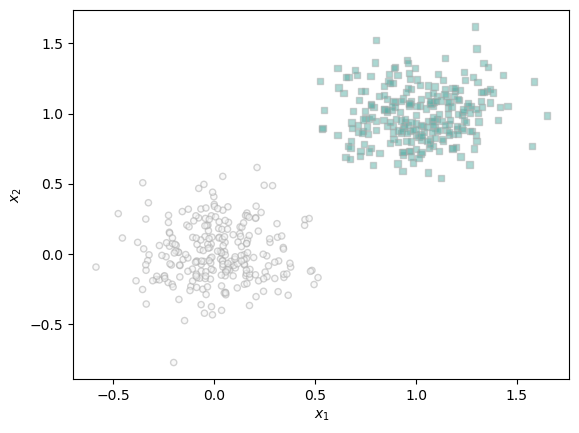

In [77]:
from matplotlib import pyplot as plt

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")


fig, ax = plt.subplots(1, 1)
X, y = classification_data(noise = 0.2)
plot_classification_data(X, y, ax)

This plot function as taken from the perceptron blog post. It shows the data set, which is currently linearly separable. Let change that! Lets increase our noise to .4. 

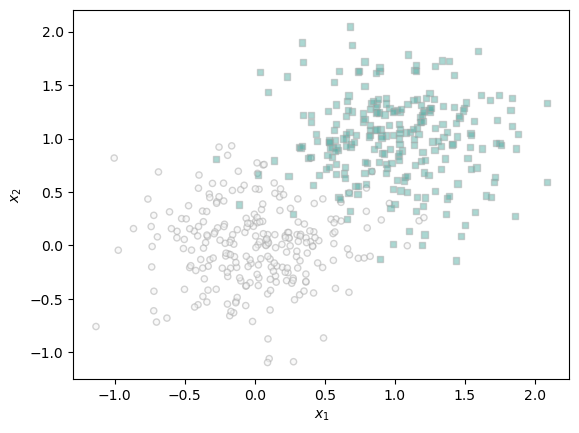

In [78]:
fig, ax = plt.subplots(1, 1)
X, y = classification_data(noise = 0.4)
plot_classification_data(X, y, ax)

We now wan to to train our model and experiment it on this new data set. We want to first try to implement Vanilla Gradient Descent. This model does not have momentum within the step function and has a relatively small learning rate, so it is a simplified version to test if our original implementation is effective

In [79]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

alpha = 0.01

for _ in range(9000):
    
    opt.step(X, y, alpha, beta = 0)

    loss = LR.loss(X, y) 
    loss_vec.append(loss)

Text(0.5, 1.0, 'Loss function over time for Vanilla Gradient DEscent')

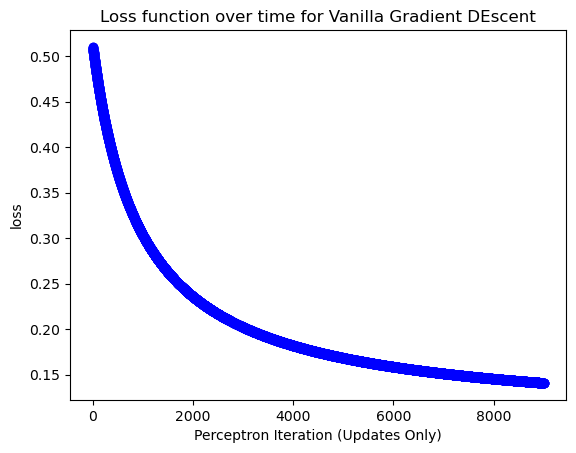

In [80]:
plt.plot(loss_vec, color = "blue")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "blue")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title("Loss function over time for Vanilla Gradient DEscent")


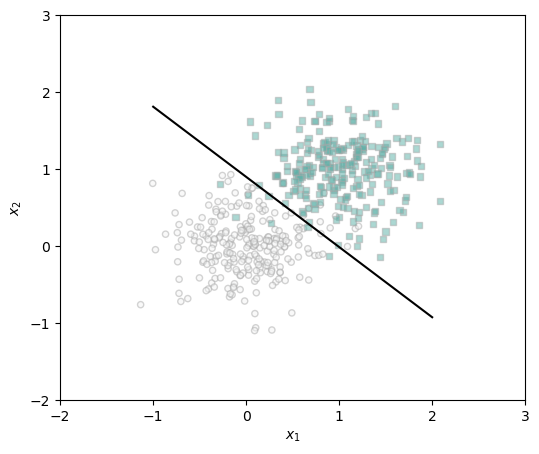

In [81]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (6, 5))
ax.set(xlim = (-2, 3), ylim = (-2, 3))
plot_classification_data(X, y, ax)
draw_line(LR.w, -1, 2, ax, color = "black")

After 9000 iterations, the graphs above shows our loss function. The code attempting to separate the data points was taken from the notes. It shows a line that is not 100% accurate but does a decent job attempting to separate the data. 

Now we are going to implement momentum to our gradient descent and see how it effect our loss function

In [82]:
loss_vec_two = []

LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(9000):
    opt.step(X, y, alpha, beta = 0.9)
    
    loss_1= LR.loss(X, y) 
    loss_vec_two.append(loss_1)

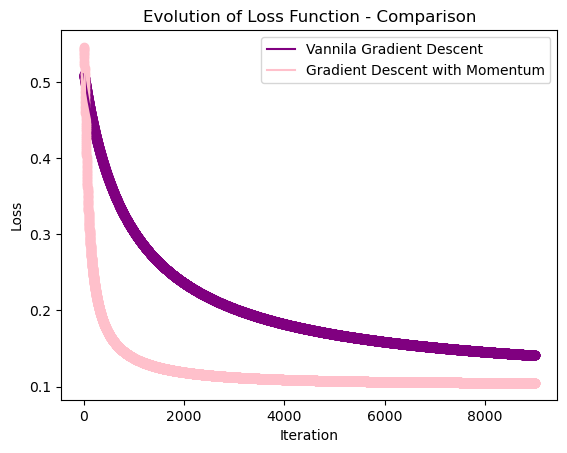

In [83]:

plt.plot(loss_vec, color="purple", label="Vannila Gradient Descent")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color="purple")

plt.plot(loss_vec_two, color="pink", label="Gradient Descent with Momentum")
plt.scatter(torch.arange(len(loss_vec_two)), loss_vec_two, color="pink")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Evolution of Loss Function - Comparison")

plt.legend()
plt.show()

As you can see, the Gradient Descent with momentum reaches the same loss as the Vanilla Gradient Descent 6000 iterations earlier. 

if we generate data were the p_dims is greater than our number of points than twe run the risk of overfitting to our training data. For my data I have each of my data sets have 100 points and my p_dims is 200. I split up the data into X_train and X_test to ensure I am training on  a different data set than I am testing on. 

In [84]:
X_train,y_train = classification_data(n_points= 50, noise = 0.4, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.4, p_dims = 100)

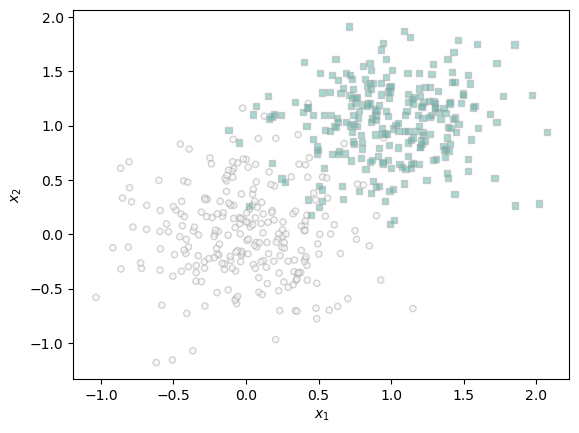

In [85]:
fig, ax = plt.subplots(1, 1)
X, y = classification_data(noise = 0.4)
plot_classification_data(X, y, ax)

Here is our data! We have 50 data points and 100 features.

We then implement linear regression on our training data. 

In [86]:
LR_2 = LogisticRegression() 
opt = GradientDescentOptimizer(LR_2)

loss_vec_three = []

for _ in range(100):

    opt.step(X_train, y_train, alpha = 0.4, beta = 0.9)
    
    loss_three = LR_2.loss(X_train, y_train).item()
    loss_vec_three.append(loss_three)

In [87]:
preds = LR_2.predict(X_train)
accurate_preds = (preds == y_train).sum()
train_acc = accurate_preds / len(y_train)
train_acc.item()

1.0

We have 100% accuracy on our training data. Now lets apply that to our testing data.

In [88]:
preds = LR_2.predict(X_test)
accurate_preds = (preds == y_test).sum()
train_acc = accurate_preds / len(y_test)
train_acc.item()

1.0

We only have 95% accuracy on our testing data, still pretty close. However, since we overfit to our training data, our training data gives 100% accuracy while our testing data only reports 95% accuracy. 

### Discussion 

Overall, this blog post taught me what background equations and computations happen within the logistic regression model. I learned that introducing momentum to the linear regression model, converges much quicker than a model without momentum. I also learned and showed the danger of overfitting a model to training data, and how it can lead to decreased accuracy on testing data. This is especially true if the dimensions of the data is more than the number of points. Overall, it was cool the debunk the complexity and mystery surrounding logistic regression and see the different elements it requires to produce a desired outcome. 
